In [1]:
import mdtraj as md
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
from scipy.optimize import curve_fit

In [2]:
traj_pro = md.load_xtc('run_pro.xtc', top = 'pro_only.gro')
traj_promb = md.load_xtc('run_promb.xtc', top = 'promb.gro')

In [3]:
xyz_pro = traj_pro.xyz
top_pro = traj_pro.topology
table_pro, bonds_pro = top_pro.to_dataframe()

xyz_promb = traj_promb.xyz
top_promb = traj_promb.topology
table_promb, bonds_promb = top_promb.to_dataframe()


#if np.max(abs(xyz_promb[:,table_promb.resName != 'DPPC',:] - xyz_pro)) < 0.1:
#    print('good!')


In [4]:
def cal_correlation_time(data):
    if (data[data<0].size>0):
        t_trunc = np.min(np.where(data<0))-1
    else:   
        t_trunc = len(data)
    params, confint = curve_fit(lambda t,a,b: a*np.exp(b*t),  np.arange(t_trunc)*dt, data[:t_trunc])
    t_correlation = -1/params[1] * 1e3 #convert µs to ns
    return t_correlation, params[0], params[1], t_trunc

In [5]:
# detection of capturing membrane

traj = md.load_xtc('run_promb.xtc', top = 'promb.gro')
xyz = traj.xyz
top = traj.topology
table, bonds = top.to_dataframe()
z_dppc = xyz[:,table.name == 'NC3',2]

z_midplane = np.mean(z_dppc, axis = 1)
z_mb_upper = np.zeros(np.shape(z_midplane))
z_mb_lower = np.zeros(np.shape(z_midplane))
z_pro_upper = np.zeros(np.shape(z_midplane))
z_pro_lower = np.zeros(np.shape(z_midplane))

z_mb_upper_error = np.zeros(np.shape(z_midplane))
z_mb_lower_error = np.zeros(np.shape(z_midplane))

for i in range(len(z_midplane)):
    temp = z_dppc[i,:]
    z_mb_upper[i] = np.mean(temp[temp>z_midplane[i]])
    z_mb_lower[i] = np.mean(temp[temp<z_midplane[i]])
    z_mb_upper_error[i] = np.std(temp[temp<z_midplane[i]])
    z_mb_lower_error[i] = np.std(temp[temp>z_midplane[i]])
    
    temp = xyz[i,table.resName != 'DPPC',2]
    z_pro_upper[i] = np.max(temp)
    z_pro_lower[i] = np.min(temp)

dt = 1e-3
t = np.arange(len(z_midplane))*dt
if (t[~((z_pro_upper > z_mb_lower) & (z_pro_lower < z_mb_upper))].size>0):
    capture_time = np.max(t[~((z_pro_upper > z_mb_lower) & (z_pro_lower < z_mb_upper))]) + dt
else:
    capture_time = 0
print('capture time = %.2f µs'%capture_time)

capture time = 13.35 µs


In [6]:
dt = 1e-3
t = np.arange(len(z_midplane))*dt
if (t[~((z_pro_upper > z_mb_lower) & (z_pro_lower < z_mb_upper))].size>0):
    capture_time = np.max(t[~((z_pro_upper > z_mb_lower) & (z_pro_lower < z_mb_upper))]) + dt
else:
    capture_time = 0
print('capture time = %.2f µs'%capture_time)

capture time = 13.35 µs


In [7]:
z_dppc = xyz_promb[:,table_promb.name == 'NC3',2]
z_midplane = np.mean(z_dppc, axis = 1)
z_mb_upper = np.zeros(np.shape(z_midplane))
z_mb_lower = np.zeros(np.shape(z_midplane))

for i in range(len(z_midplane)):
    temp = z_dppc[i,:]
    z_mb_upper[i] = np.mean(temp[temp>z_midplane[i]])
    z_mb_lower[i] = np.mean(temp[temp<z_midplane[i]])


In [8]:
n_timestep = np.shape(xyz_pro)[0]
n_beads = np.shape(xyz_pro)[1]

dt = 1e-3
t = np.arange(n_timestep)*dt

center_pro = np.mean(xyz_pro, axis=1)
xyz_pro_cali = xyz_pro - np.repeat(center_pro[:,np.newaxis,:], n_beads, axis =1)
xyz_pro_cali_mb = xyz_pro.copy()
xyz_pro_cali_mb[:,:,2] = xyz_pro[:,:,2] - np.repeat(z_mb_upper[:,np.newaxis], n_beads, axis =1)
xyz_pro_cali_mb[:,:,0] = xyz_pro[:,:,0] - np.repeat(center_pro[:,np.newaxis,0], n_beads, axis =1)
xyz_pro_cali_mb[:,:,1] = xyz_pro[:,:,1] - np.repeat(center_pro[:,np.newaxis,1], n_beads, axis =1)

In [9]:
m_t = np.zeros((n_timestep,3,3))
gr_t = np.zeros(n_timestep)
gr_xy_t = np.zeros(n_timestep)
eigen_xy_t = np.zeros((n_timestep, 2))
asp_ratio_t = np.zeros(n_timestep)

for i in range(n_timestep):
    m_t[i,:,:] = np.dot(xyz_pro_cali[i,:,:].T, xyz_pro_cali[i,:,:])/n_beads
    gr_t[i] = np.sqrt(np.sum(np.diag(m_t[i,:,:])))
    gr_xy_t[i] = np.sqrt(np.sum(np.diag(m_t[i,:-1,:-1])))
    eigen_xy_t[i,:] = la.eigvals(m_t[i,:-1,:-1])
    asp_ratio_t[i] = np.sqrt(np.max(eigen_xy_t[i,:]) / np.min(eigen_xy_t[i,:]))

In [10]:
plt.rcParams['font.family'] = "Helvetica"
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 2

In [ ]:
817-826, 847-850

In [13]:
(table_pro.resSeq>1)&(table_pro.resSeq<12)

0     False
1     False
2      True
3      True
4      True
      ...  
81    False
82    False
83    False
84    False
85    False
Name: resSeq, Length: 86, dtype: bool

In [17]:
xyz_helix1 = np.mean(xyz_pro_cali_mb[:, (table_pro.resSeq>1)&(table_pro.resSeq<12), :], axis=1)
xyz_helix2 = np.mean(xyz_pro_cali_mb[:, (table_pro.resSeq>31)&(table_pro.resSeq<36), :], axis=1)

In [18]:
helix_sep_xy = np.linalg.norm((xyz_helix1 - xyz_helix2)[:,:2], axis=1)

In [92]:
np.min(helix_sep_xy)

0.014871456

[]

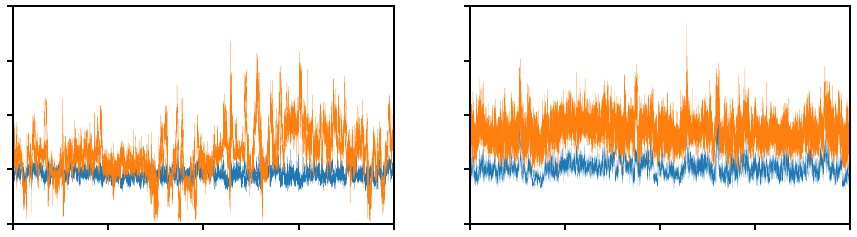

In [20]:
lw = 0.2
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(t, width_t*2, lw=lw)
plt.plot(t, helix_sep_xy, lw=lw)
plt.xlim([0,20])
plt.ylim([0,4])
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

#plt.plot(t, gr_xy_t, lw=0.2)

plt.subplot(122)
plt.plot(t, 2*depth_t, lw=0.1)
plt.plot(t, loop_thickness, lw=lw)
plt.xlim([0,20])
plt.ylim([0,4])
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

NameError: name 'depth_t' is not defined

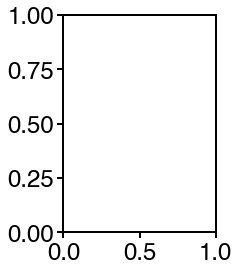

In [12]:
xyz_loop = xyz_pro_cali_mb[:, (table_pro.resSeq>11)&(table_pro.resSeq<32), :]
loop_thickness = np.max(xyz_loop[:,:,2], axis=1) - np.min(xyz_loop[:,:,2], axis=1)
plt.subplot(121)
plt.plot(t, depth_t, lw=0.2)
plt.subplot(122)
plt.plot(t, loop_thickness/2, lw=0.2)

The gyration tensor M is defined as

$M = <<\overrightarrow{r_i}\otimes\overrightarrow{r_i}>_i>_t = <<{\begin{bmatrix}x_{i}x_{i}&x_{i}y_{i}&x_{i}z_{i}\\x_{i}y_{i}&y_{i}y_{i}&y_{i}z_{i}\\x_{i}z_{i}&y_{i}z_{i}&z_{i}z_{i}\end{bmatrix}}>_i>_t
= {\begin{bmatrix}M_{xx}&M_{xy}&M_{xz}\\M_{xy}&M_{yy}&M_{yz}\\M_{xz}&M_{yz}&M_{zz}\end{bmatrix}}
$

The radius of gyration is defined to be the square root of the sum of the diagonal components of the gyration tensor.

$R_{g} = \sqrt{M_{xx} + M_{yy} + M_{zz}}$

The radius of gyration in xy plane is defined to be

$R_{g}^{xy} = \sqrt{M_{xx} + M_{yy}}$

Radius of gyration = 1.05 ± 0.08 nm
XY-plane radius of gyration = 0.92 ± 0.11 nm


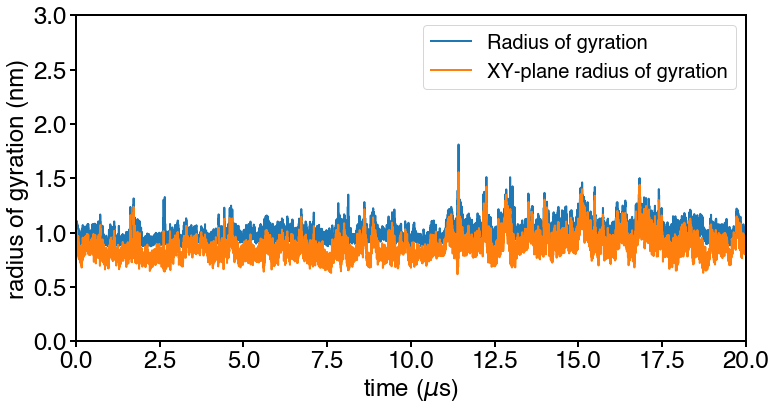

In [13]:
plt.figure(figsize=(12,6))
plt.plot(t, gr_t, lw=2, label='Radius of gyration')
plt.plot(t, gr_xy_t, lw=2, label='XY-plane radius of gyration')
plt.legend(('Radius of gyration', 'XY-plane radius of gyration'), fontsize=20)
#plt.plot([capture_time, capture_time], [0,2], 'k--')
#plt.text(capture_time, 1.5, 'capture', fontsize=24)
plt.xlabel('time ($\mu$s)')
plt.ylabel('radius of gyration (nm)')
plt.xlim([0,20])
plt.ylim([0,3])

print('Radius of gyration = %.2f ± %.2f nm'%(np.mean(gr_t[t>capture_time]), np.std(gr_t[t>capture_time])))
print('XY-plane radius of gyration = %.2f ± %.2f nm'%(np.mean(gr_xy_t[t>capture_time]), np.std(gr_xy_t[t>capture_time])))

Gyration Radius

The length and width of the FP comes from the xy components of the gyration tensor M. 

$M_{xy} = {\begin{bmatrix}M_{xx}&M_{xy}\\M_{xy}&M_{yy}\end{bmatrix}}
$

$M_{xy}$ has two positive eigenvalues $\lambda_1$ and $\lambda_2$ and suppose $\lambda_1 > \lambda_2$, then the length $L$ and the width $W$ is defined as

$
L = \sqrt{\lambda_1} \\
W = \sqrt{\lambda_2}
$

The thickness of the FP D comes from the z component of the gyration tensor diagonal.

$D = \sqrt{M_{zz}} $

Length = 0.79 ± 0.13 nm
Width = 0.46 ± 0.06 nm
Thickness = 0.50 ± 0.08 nm


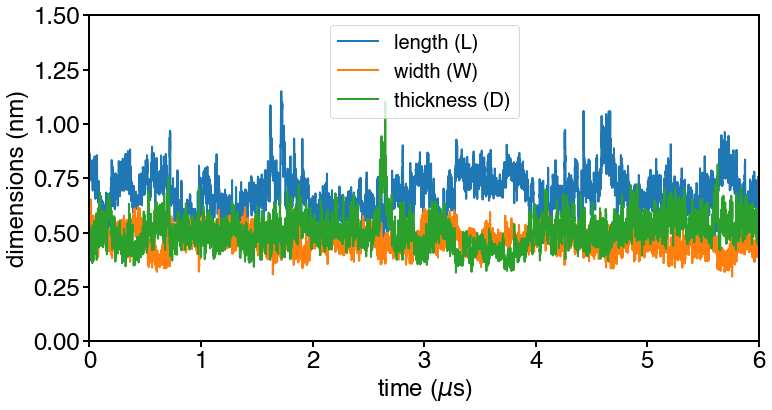

In [14]:
plt.figure(figsize=(12,6))
length_t = np.sqrt(np.max(eigen_xy_t, axis=1))
width_t = np.sqrt(np.min(eigen_xy_t, axis=1))
depth_t = np.sqrt(m_t[:,2,2])

plt.plot(t, length_t, lw=2, label='length (L)')
plt.plot(t, width_t, lw=2, label='width (W)')
plt.plot(t, depth_t, lw=2, label='thickness (D)')
plt.legend(('length (L)', 'width (W)', 'thickness (D)'), fontsize=20)
#plt.plot([capture_time, capture_time], [0,2], 'k--')
#plt.text(capture_time, 1.5, 'capture', fontsize=24)
plt.xlabel('time ($\mu$s)')
plt.ylabel('dimensions (nm)')
plt.xlim([0,6])
plt.ylim([0,1.5])

print('Length = %.2f ± %.2f nm'%(np.mean(length_t[t>capture_time]), np.std(length_t[t>capture_time])))
print('Width = %.2f ± %.2f nm'%(np.mean(width_t[t>capture_time]), np.std(width_t[t>capture_time])))
print('Thickness = %.2f ± %.2f nm'%(np.mean(depth_t[t>capture_time]), np.std(depth_t[t>capture_time])))

The aspect ratio is the ratio between the length $L$ and the widht $W$.

aspect ratio = $L / W$

(0.0, 6.0)

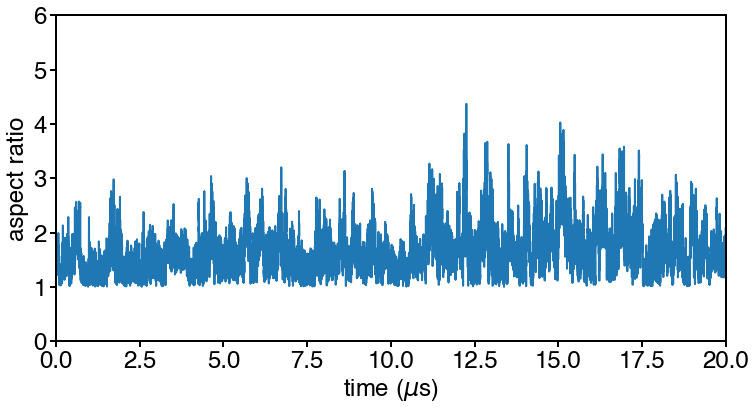

In [15]:
plt.figure(figsize=(12,6))
plt.plot(t, asp_ratio_t, lw=2, label='Aspect ratio')
#plt.plot([capture_time, capture_time], [0,6], 'k--')
#plt.text(capture_time, 5, 'capture', fontsize=24)
plt.xlabel('time ($\mu$s)')
plt.ylabel('aspect ratio')
plt.xlim([0,20])
plt.ylim([0,6])

Text(0.5, 0.04, 'time ($\\mu$s)')

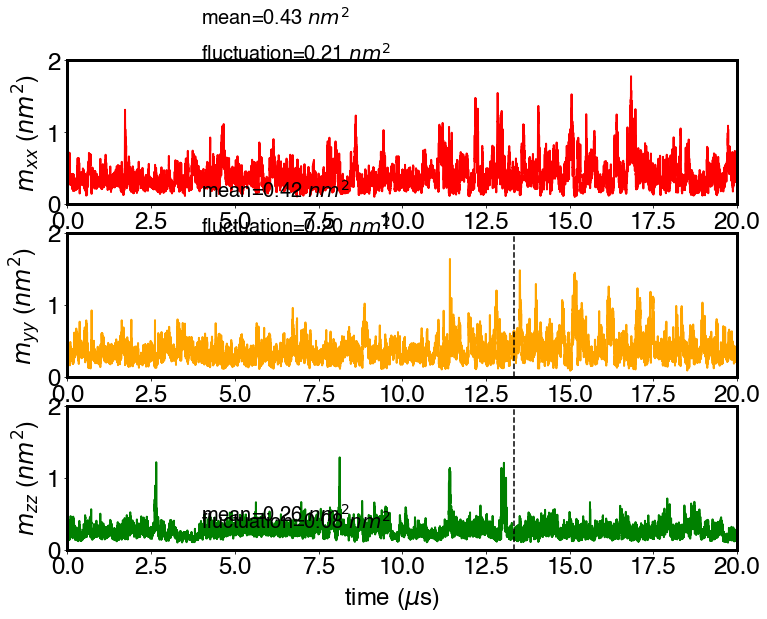

In [29]:
fig = plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.plot(t, m_t[:,0,0], lw=2, color = 'red')
#plt.plot([capture_time, capture_time], [0,3], 'k--')
#plt.text(capture_time, 2, 'capture', fontsize=24)
plt.text(4,2.5,'mean=%.2f $nm^2$'%np.mean(m_t[t>capture_time,0,0]), fontsize=20)
plt.text(4,2,'fluctuation=%.2f $nm^2$'%np.std(m_t[t>capture_time,0,0]), fontsize=20)
plt.xlim([0,20])
plt.ylim([0,2])
plt.ylabel('$m_{xx}$ ($nm^2$)')

plt.subplot(3,1,2)
plt.plot(t, m_t[:,1,1], lw=2, color = 'orange')
plt.plot([capture_time, capture_time], [0,3], 'k--')
plt.text(4,2.5,'mean=%.2f $nm^2$'%np.mean(m_t[t>capture_time,1,1]), fontsize=20)
plt.text(4,2,'fluctuation=%.2f $nm^2$'%np.std(m_t[t>capture_time,1,1]), fontsize=20)
plt.xlim([0,20])
plt.ylim([0,2])
plt.ylabel('$m_{yy}$ ($nm^2$)')

plt.subplot(3,1,3)
plt.plot(t, m_t[:,2,2], lw=2, color = 'green')
plt.plot([capture_time, capture_time], [0,3], 'k--')
plt.text(4,0.4,'mean=%.2f $nm^2$'%np.mean(m_t[t>capture_time,2,2]), fontsize=20)
plt.text(4,0.3,'fluctuation=%.2f $nm^2$'%np.std(m_t[t>capture_time,2,2]), fontsize=20)
plt.xlim([0,20])
plt.ylim([0,2])
plt.ylabel('$m_{zz}$ ($nm^2$)')

fig.text(0.5, 0.04, 'time ($\mu$s)', ha='center', fontsize=24)

Text(0.5, 0.04, 'time ($\\mu$s)')

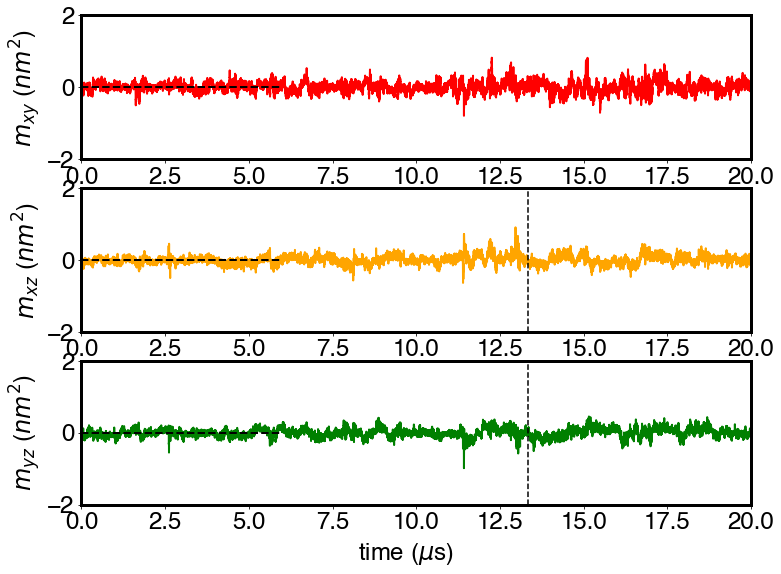

In [30]:
fig = plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.plot(t, m_t[:,0,1], lw=2, color = 'red')
plt.plot([0,6],[0,0], 'k--', lw=2)
#plt.plot([capture_time, capture_time], [-2,2], 'k--')
#plt.text(capture_time, 1, 'capture', fontsize=24)
plt.xlim([0,20])
plt.ylim([-2,2])
plt.ylabel('$m_{xy}$ ($nm^2$)')

plt.subplot(3,1,2)
plt.plot(t, m_t[:,0,2], lw=2, color = 'orange')
plt.plot([0,6],[0,0], 'k--', lw=2)
plt.plot([capture_time, capture_time], [-2,2], 'k--')
plt.xlim([0,20])
plt.ylim([-2,2])
plt.ylabel('$m_{xz}$ ($nm^2$)')

plt.subplot(3,1,3)
plt.plot(t, m_t[:,1,2], lw=2, color = 'green')
plt.plot([0,6],[0,0], 'k--', lw=2)
plt.plot([capture_time, capture_time], [-2,2], 'k--')
plt.xlim([0,20])
plt.ylim([-2,2])
plt.ylabel('$m_{yz}$ ($nm^2$)')

fig.text(0.5, 0.04, 'time ($\mu$s)', ha='center', fontsize=24)


mxx+myy correlation time = 50 ns
mzz correlation time = 71 ns


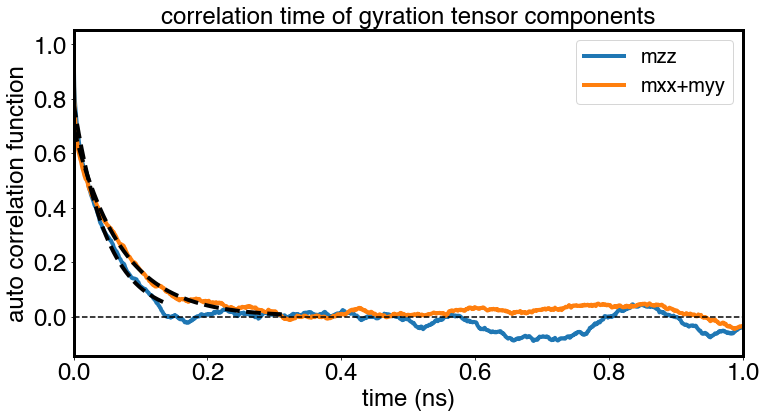

In [116]:
from statsmodels.tsa.stattools import acf
lags = 1000

acf_mxxyy = acf(m_t[:10000,0,0]+m_t[:10000,1,1], nlags=lags, fft=False)
t_correlation_mxxyy, c_mxxyy1, c_mxxyy2, t_trunc_mxxyy = cal_correlation_time(acf_mxxyy) 
print('mxx+myy correlation time = %.0f ns'%t_correlation_mxxyy)

acf_mzz = acf(m_t[:,2,2], nlags=lags, fft=False)
t_correlation_mzz, c_mzz1, c_mzz2, t_trunc_mzz = cal_correlation_time(acf_mzz) 
print('mzz correlation time = %.0f ns'%t_correlation_mzz)


plt.figure(figsize=(12,6))
plt.plot(np.arange(lags+1)*dt, acf_mxxyy, linewidth=4)
plt.plot(np.arange(lags+1)*dt, acf_mzz, linewidth=4)
plt.plot([0,lags*dt],[0,0], 'k--')
plt.plot(np.arange(t_trunc_mxxyy+1)*dt, c_mxxyy1* np.exp(np.arange(t_trunc_mxxyy+1)*dt*c_mxxyy2), '--', linewidth=4, color='k')
plt.plot(np.arange(t_trunc_mzz+1)*dt, c_mzz1* np.exp(np.arange(t_trunc_mzz+1)*dt*c_mzz2), '--', linewidth=4, color='k')
plt.xlim([0,lags*dt])
plt.xlabel('time (ns)')
plt.ylabel('auto correlation function')
plt.title('correlation time of gyration tensor components', fontsize=24)
plt.legend(('mzz','mxx+myy'),fontsize=20)


Gyration radius correlation time = 868 ns


Text(0, 0.5, 'auto correlation function')

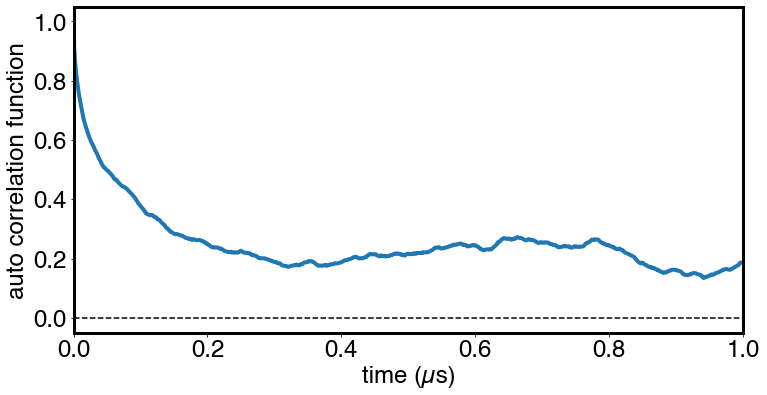

In [92]:
from statsmodels.tsa.stattools import acf
lags = 1000

acf_gr = acf(gr_t, nlags=lags, fft=False)
t_correlation_gr, c_gr1, c_gr2, t_trunc_gr = cal_correlation_time(acf_gr) 
print('Gyration radius correlation time = %.0f ns'%t_correlation_gr)


plt.figure(figsize=(12,6))
plt.plot(np.arange(lags+1)*dt, acf_gr, linewidth=4)
plt.plot([0,lags*dt],[0,0], 'k--')
plt.xlim([0,lags*dt])
plt.xlabel('time (µs)')
plt.ylabel('auto correlation function')


In [111]:
gr_t2 = gr_t.copy()
np.shape(gr_t2)

(20001,)

Text(0, 0.5, 'auto correlation function')

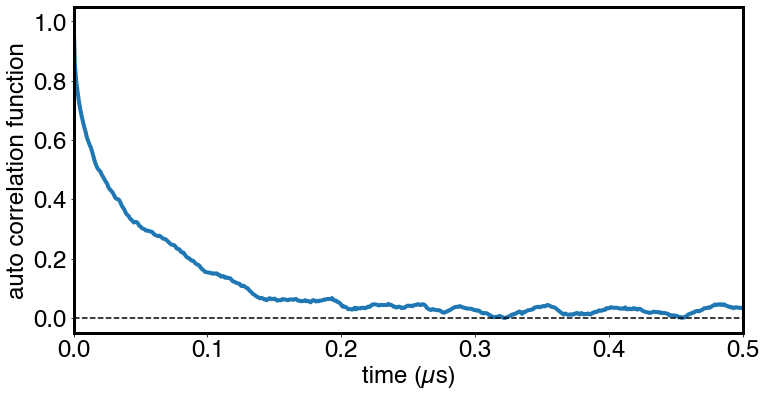

In [121]:
lags = 500
acf_gr2 = acf(gr_t2[:10000], nlags=lags, fft=False)


plt.figure(figsize=(12,6))
plt.plot(np.arange(lags+1)*dt, acf_gr2, linewidth=4)
plt.plot([0,lags*dt],[0,0], 'k--')
plt.xlim([0,lags*dt])
plt.xlabel('time (µs)')
plt.ylabel('auto correlation function')


<ipython-input-122-6f8f7a30282c>:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.arange(lags+1)*dt, np.log(acf_gr2))


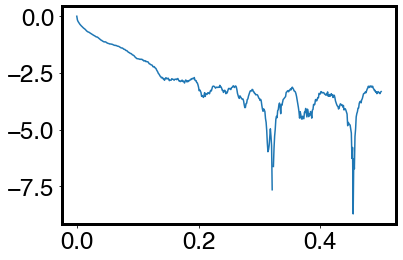

In [122]:
plt.plot(np.arange(lags+1)*dt, np.log(acf_gr2))

(0.0, 10.0)

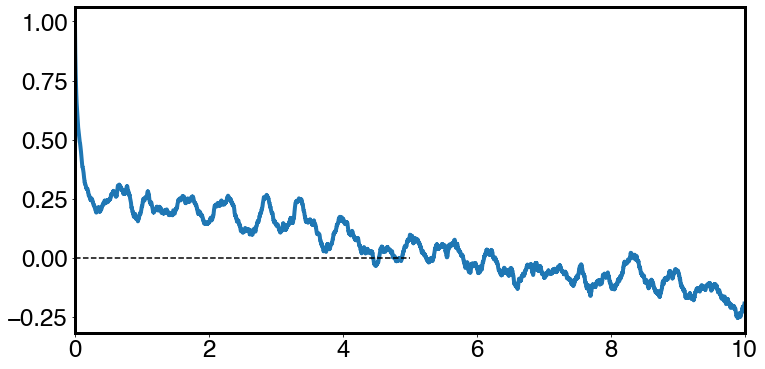

In [77]:
acf_test = np.zeros(10000)
for i in range(len(acf_test)):
    acf_test[i] = np.mean((gr_t[i+1:]-np.mean(gr_t))*(gr_t[:-(i+1)]-np.mean(gr_t)))
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(acf_test))/1000, acf_test/acf_test[0],linewidth=4)
plt.plot([0,lags*dt],[0,0], 'k--')
plt.xlim([0,10000*dt])



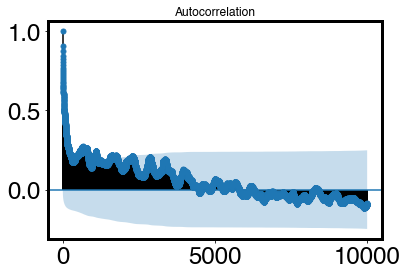

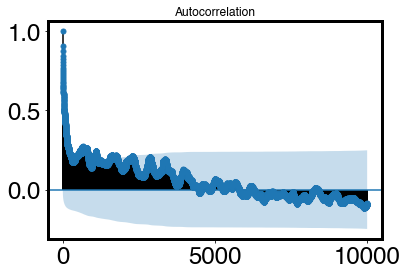

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(gr_t, lags=10000)

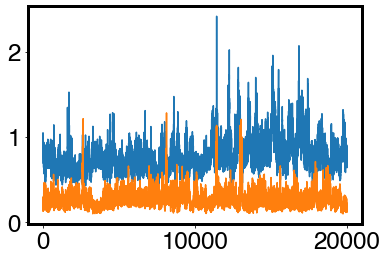

In [37]:
plt.plot(m_t[:,0,0]+m_t[:,1,1])
plt.plot(m_t[:,2,2])

In [38]:
np.argmax(m_t[:,0,0] + m_t[:,1,1])

11424

Text(0.5, 0, 'time ($\\mu$s)')

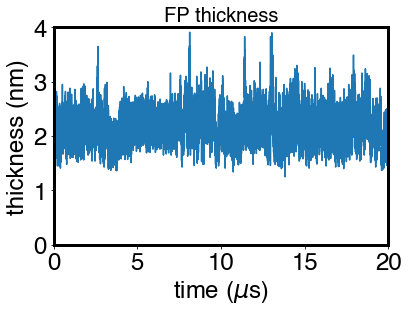

In [33]:
plt.title('FP thickness', fontsize=20)
plt.plot(t, z_pro_upper - z_pro_lower)
plt.xlim([0,20])
plt.ylim([0,4])
plt.ylabel('thickness (nm)')
plt.xlabel('time ($\mu$s)')

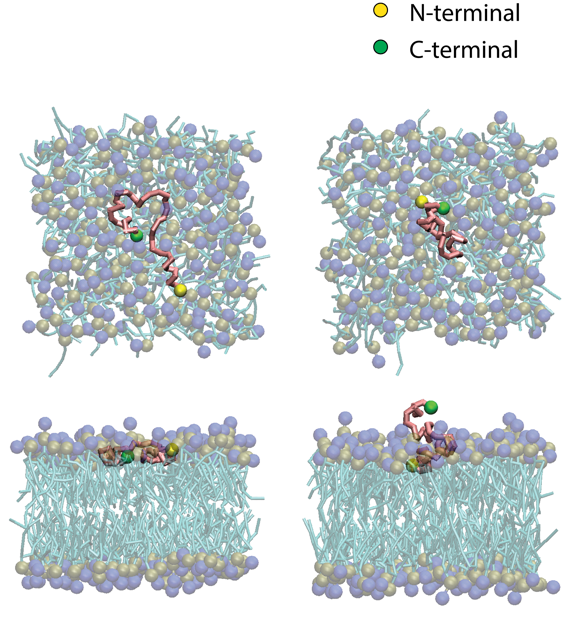

In [22]:
from PIL import Image
image = Image.open("two_states.png")
image.resize((int(image.size[0]/4),int(image.size[1]/4)))


NameError: name 'c_t' is not defined

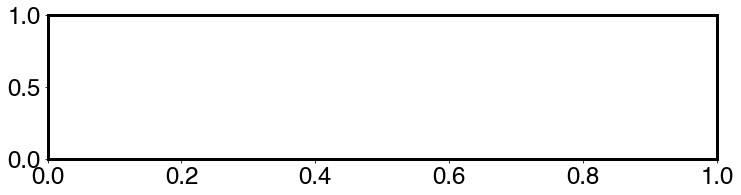

In [23]:
lags = 2000
t_c = np.arange(lags+1) * 3.0 / 1e4
fig = plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.plot(t_c, c_t[:,0,1], lw=2, color = 'red')
#plt.plot([0,6],[0,0], 'k--', lw=2)
#plt.plot([capture_time, capture_time], [-2,2], 'k--')
#plt.text(capture_time, 1, 'capture', fontsize=24)
#plt.xlim([0,6])
plt.ylim([-0.1,0.1])
plt.ylabel('$c_{xy}$ ($nm^2$)')

plt.subplot(3,1,2)
plt.plot(t_c, c_t[:,0,2], lw=2, color = 'orange')
#plt.plot([0,6],[0,0], 'k--', lw=2)
#plt.plot([capture_time, capture_time], [-2,2], 'k--')
#plt.xlim([0,6])
plt.ylim([-0.1,0.1])
plt.ylabel('$c_{xz}$ ($nm^2$)')

plt.subplot(3,1,3)
plt.plot(t_c, c_t[:,1,2], lw=2, color = 'green')
#plt.plot([0,6],[0,0], 'k--', lw=2)
#plt.plot([capture_time, capture_time], [-2,2], 'k--')
#plt.xlim([0,6])
plt.ylim([-0.1,0.1])
plt.ylabel('$c_{yz}$ ($nm^2$)')

fig.text(0.5, 0.04, 'time ($\mu$s)', ha='center', fontsize=24)

mean insertion depth = -0.29 nm


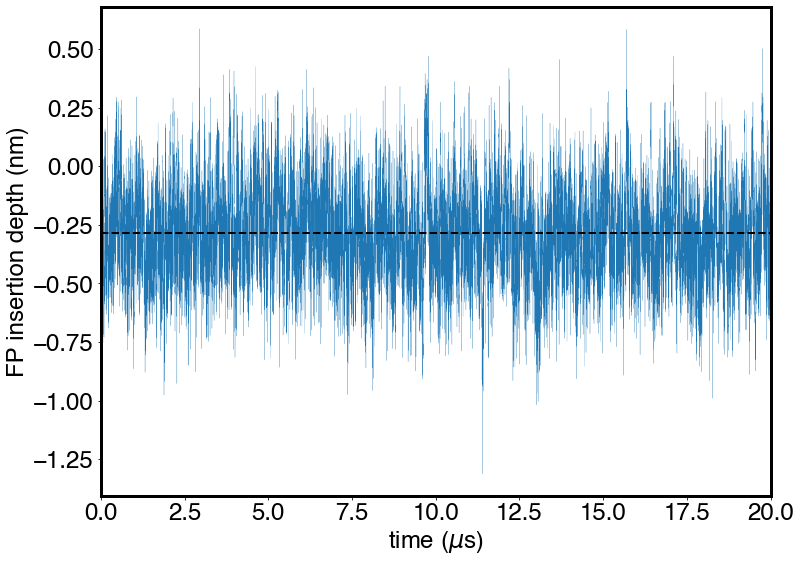

In [41]:
insertion_depth = z_mb_upper - np.mean(xyz_pro[:,:,2],axis=1)
plt.figure(figsize=(12,9))
plt.plot(np.arange(n_timestep)*dt, insertion_depth,linewidth=0.2)
plt.plot([0,20],[np.mean(insertion_depth),np.mean(insertion_depth)], 'k--', linewidth=2)
plt.xlabel('time ($\mu$s)')
plt.xlim([0,20])
plt.ylabel('FP insertion depth (nm)')
#plt.ylim([0,1.2])
print('mean insertion depth = %.2f nm'%np.mean(insertion_depth))

In [42]:
n_residue = 40
insertion_depth_residue = np.zeros((n_residue, n_timestep))
insertion_depth_residue_t_correlation = np.zeros((n_residue))
lags = 2000
for i in range(n_residue):
    insertion_depth_residue[i,:] = z_mb_upper - np.mean(xyz_pro[:,table_pro.resSeq==i+1,2], axis =1)
    insertion_depth_residue_t_correlation[i], b,c,d= cal_correlation_time(acf(insertion_depth_residue[i,:], nlags=lags, fft=False))
mean_insertion_depth_residue = np.mean(insertion_depth_residue, axis=1)
fluc_insertion_depth_residue = np.std(insertion_depth_residue, axis=1)

Text(0.5, 0, 'residue number')

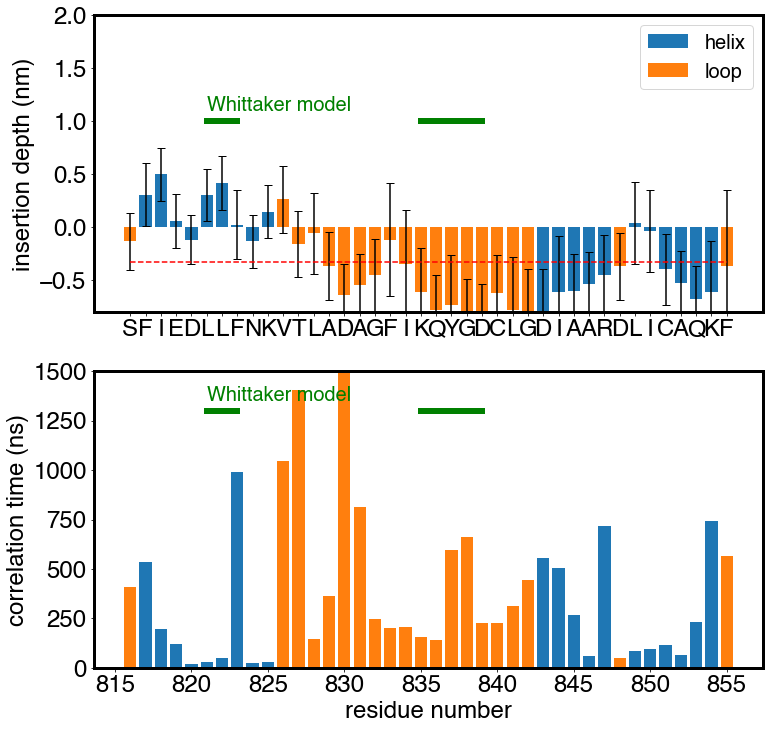

In [43]:
helix = np.array([817,818,819,820,821,822,823,824,825,843,844,845,846,847,849,850,851,852,853,854])-816
loop = np.array(list(set(np.arange(n_residue)) - set(helix)))
whittaker1 = [821,822,823]
whittaker2 = [835,836,837,838,839]

fig = plt.figure(figsize=(12,12))
plt.subplot(211)
plt.bar(helix+816,mean_insertion_depth_residue[helix],yerr=fluc_insertion_depth_residue[helix],capsize=4)
plt.bar(loop+816,mean_insertion_depth_residue[loop],yerr=fluc_insertion_depth_residue[loop],capsize=4)
plt.legend(('helix','loop'), fontsize=20)
plt.plot([816,855],[np.mean(mean_insertion_depth_residue),np.mean(mean_insertion_depth_residue)],'r--')
plt.plot(whittaker1, np.ones(np.shape(whittaker1))*1.0, linewidth=6, color='green')
plt.plot(whittaker2, np.ones(np.shape(whittaker2))*1.0, linewidth=6, color='green')
plt.text(821,1.1,'Whittaker model', fontsize=20, color='green')
plt.xticks(np.arange(n_residue)+816, labels='SFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFN')
plt.ylabel('insertion depth (nm)')
plt.ylim([-0.8,2])

plt.subplot(212)
plt.bar(helix+816, insertion_depth_residue_t_correlation[helix])
plt.bar(loop+816, insertion_depth_residue_t_correlation[loop])
plt.plot(whittaker1, np.ones(np.shape(whittaker1))*1300, linewidth=6, color='green')
plt.plot(whittaker2, np.ones(np.shape(whittaker2))*1300, linewidth=6, color='green')
plt.text(821,1350,'Whittaker model', fontsize=20, color='green')
plt.ylim([0,1500])
plt.ylabel('correlation time (ns)')
plt.xlabel('residue number')


Text(0, 0.5, 'correlation time (ns)')

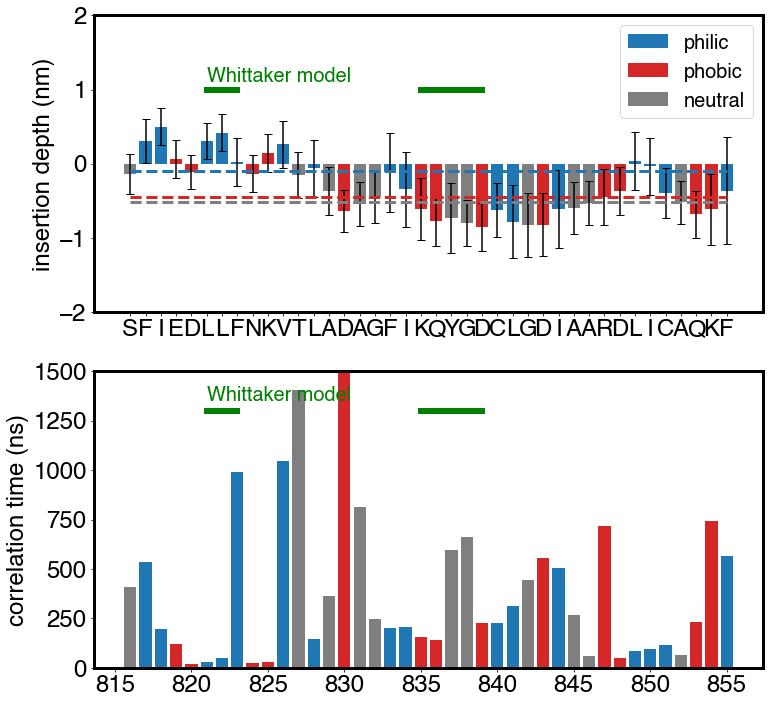

In [118]:
philic = np.array([817,818,821,822,823,826,828,833,834,840,841,844,849,850,851,855])-816
phobic = np.array([819,820,824,825,830,835,836,839,843,847,848,853,854])-816
neutral = np.sort(np.array(list(set(np.arange(n_residue)) - set(philic) - set(phobic))))

fig = plt.figure(figsize=(12,12))
plt.subplot(211)
plt.bar(philic+816,mean_insertion_depth_residue[philic],yerr=fluc_insertion_depth_residue[philic],capsize=4,color='tab:blue')
plt.bar(phobic+816,mean_insertion_depth_residue[phobic],yerr=fluc_insertion_depth_residue[phobic],capsize=4,color='tab:red')
plt.bar(neutral+816,mean_insertion_depth_residue[neutral],yerr=fluc_insertion_depth_residue[neutral],capsize=4,color='tab:grey')
plt.legend(('philic','phobic','neutral'), fontsize=20)#,ncol=3)
plt.plot([816,855],[np.mean(mean_insertion_depth_residue[philic]),np.mean(mean_insertion_depth_residue[philic])],'--',color = 'tab:blue', linewidth=3)
plt.plot([816,855],[np.mean(mean_insertion_depth_residue[phobic]),np.mean(mean_insertion_depth_residue[phobic])],'--',color = 'tab:red', linewidth=3)
plt.plot([816,855],[np.mean(mean_insertion_depth_residue[neutral]),np.mean(mean_insertion_depth_residue[neutral])],'--',color = 'tab:grey', linewidth=3)
plt.plot(whittaker1, np.ones(np.shape(whittaker1))*1.0, linewidth=6, color='green')
plt.plot(whittaker2, np.ones(np.shape(whittaker2))*1.0, linewidth=6, color='green')
plt.text(821,1.1,'Whittaker model', fontsize=20, color='green')
plt.xticks(np.arange(n_residue)+816, labels='SFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFN')
plt.ylabel('insertion depth (nm)')
plt.ylim([-2,2])

plt.subplot(212)
plt.bar(philic+816, insertion_depth_residue_t_correlation[philic],color = 'tab:blue')
plt.bar(phobic+816, insertion_depth_residue_t_correlation[phobic],color = 'tab:red')
plt.bar(neutral+816, insertion_depth_residue_t_correlation[neutral],color = 'tab:grey')
plt.plot(whittaker1, np.ones(np.shape(whittaker1))*1300, linewidth=6, color='green')
plt.plot(whittaker2, np.ones(np.shape(whittaker2))*1300, linewidth=6, color='green')
plt.text(821,1350,'Whittaker model', fontsize=20, color='green')
plt.ylim([0,1500])
plt.ylabel('correlation time (ns)')

In [45]:
t = [];
coul = [];
lj = [];

with open("total_continue_coul.xvg") as f:
    for line in f:
        cols = line.split()
        
        if (cols[0][0] == '@'):
            continue
        
        elif len(cols) == 2:
            t.append(float(cols[0]))
            coul.append(float(cols[1]))

with open("total_continue_lj.xvg") as f:
    for line in f:
        cols = line.split()

        if (cols[0][0] == '@'):
            continue
        
        elif len(cols) == 2:
            lj.append(float(cols[1]))

IE = np.array(coul) + np.array(lj)
IE_kT = IE / 2.479

FileNotFoundError: [Errno 2] No such file or directory: 'total_continue_coul.xvg'

Interaction energy correlation time = 239 ns


Text(0, 0.5, 'auto correlation function')

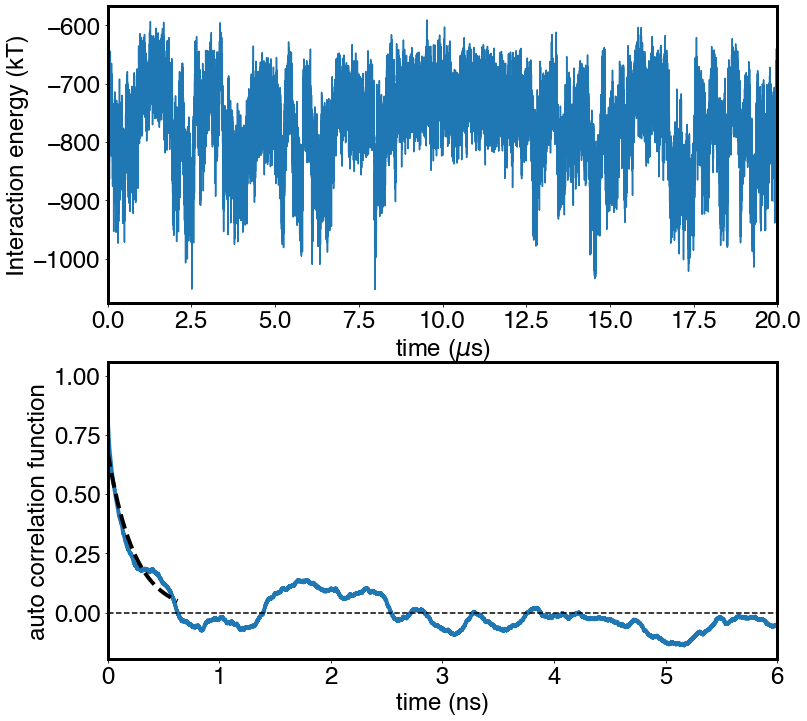

In [29]:
fig = plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(np.arange(len(IE))*0.0003,IE_kT)
plt.xlim([0,20])
plt.ylabel('Interaction energy (kT)')
plt.xlabel('time ($\mu$s)')

plt.subplot(212)
lags = 20000

acf_IE = acf(IE, nlags=lags, fft=False)
t_correlation_IE, c_IE1, c_IE2, t_trunc_IE = cal_correlation_time(acf_IE) 
print('Interaction energy correlation time = %.0f ns'%t_correlation_IE)
plt.plot(np.arange(lags+1)*3.0/1e4, acf_IE, linewidth=4)
plt.plot([0,lags*3.0/1e4],[0,0], 'k--')
plt.plot(np.arange(t_trunc_IE+1)*3.0/1e4, c_IE1* np.exp(np.arange(t_trunc_IE+1)*3/1e4*c_IE2), '--', linewidth=4, color='k')
plt.xlim([0,lags*3.0/1e4])
plt.xlabel('time (ns)')
plt.ylabel('auto correlation function')


In [63]:
lags = 5000

acf_length = acf(length_t, nlags=lags, fft=False)
t_correlation_length, c_length1, c_length2, t_trunc_length = cal_correlation_time(acf_length) 
print('Length correlation time = %.0f ns'%t_correlation_length)

acf_width = acf(width_t, nlags=lags, fft=False)
t_correlation_width, c_width1, c_width2, t_trunc_width = cal_correlation_time(acf_width) 
print('Width correlation time = %.0f ns'%t_correlation_width)

acf_depth = acf(depth_t, nlags=lags, fft=False)
t_correlation_depth, c_depth1, c_depth2, t_trunc_depth = cal_correlation_time(acf_depth) 
print('Depth correlation time = %.0f ns'%t_correlation_depth)

acf_asp = acf(asp_ratio_t, nlags=lags, fft=False)
t_correlation_asp, c_asp1, c_asp2, t_trunc_asp = cal_correlation_time(acf_asp) 
print('Aspect ratio correlation time = %.0f ns'%t_correlation_asp)

acf_ins = acf(insertion_depth, nlags=lags, fft=False)
t_correlation_ins, c_ins1, c_ins2, t_trunc_ins = cal_correlation_time(acf_ins) 
print('Insertion depth correlation time = %.0f ns'%t_correlation_ins)

acf_gr = acf(gr_t, nlags=lags, fft=False)
t_correlation_gr, c_gr1, c_gr2, t_trunc_gr = cal_correlation_time(acf_gr) 
print('Gyration radius correlation time = %.0f ns'%t_correlation_gr)

acf_grxy = acf(gr_xy_t, nlags=lags, fft=False)
t_correlation_grxy, c_grxy1, c_grxy2, t_trunc_grxy = cal_correlation_time(acf_grxy) 
print('xy-plane gyration radius correlation time = %.0f ns'%t_correlation_grxy)

Length correlation time = 2943 ns
Width correlation time = 46 ns
Depth correlation time = 84 ns
Aspect ratio correlation time = 155 ns
Insertion depth correlation time = 16 ns
Gyration radius correlation time = 2922 ns
xy-plane gyration radius correlation time = 3257 ns


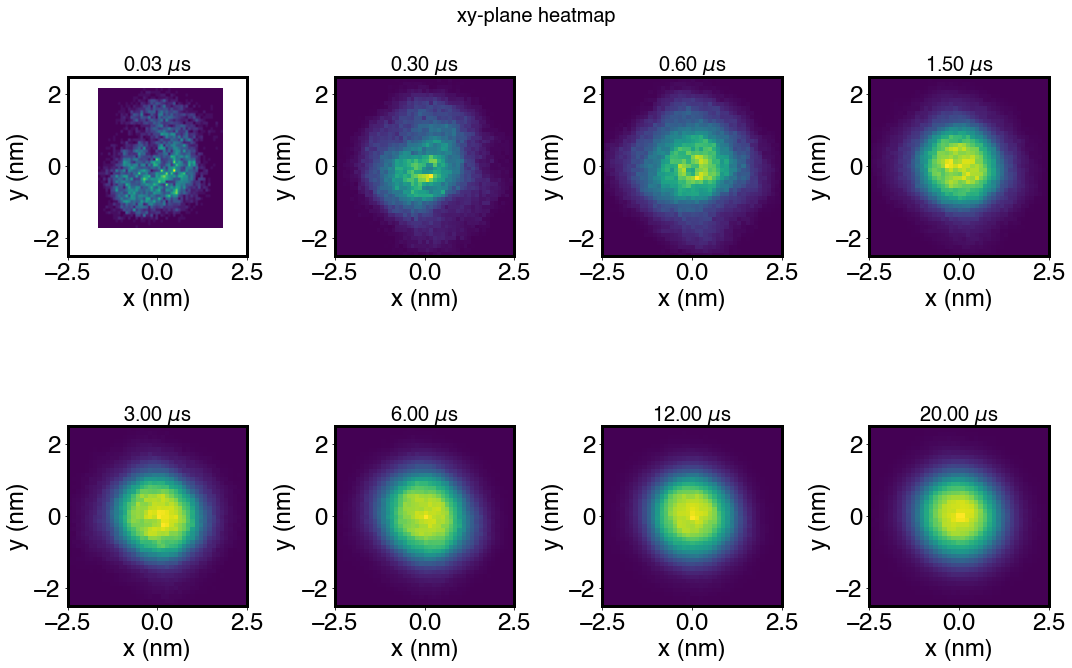

In [70]:
t_plot = np.array([100,1000,2000,5000,10000,20000,40000,np.shape(xyz_pro_cali)[0]])
fig = plt.figure(figsize=(15,10))
fig.suptitle('xy-plane heatmap', fontsize = 20)
for i in range(len(t_plot)):
    heatmap, xedges, yedges = np.histogram2d(xyz_pro_cali[:t_plot[i],:,0].ravel(), xyz_pro_cali[:t_plot[i],:,1].ravel(), bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.subplot(2,4,i+1)
    plt.imshow(heatmap.T, extent = extent, origin='lower')
    plt.xlim([-2.5,2.5])
    plt.ylim([-2.5,2.5])
    plt.xlabel('x (nm)')
    plt.ylabel('y (nm)')
    plt.title('%.2f $\mu$s'%(t_plot[i]*3/1e4), fontsize=20)
fig.tight_layout()

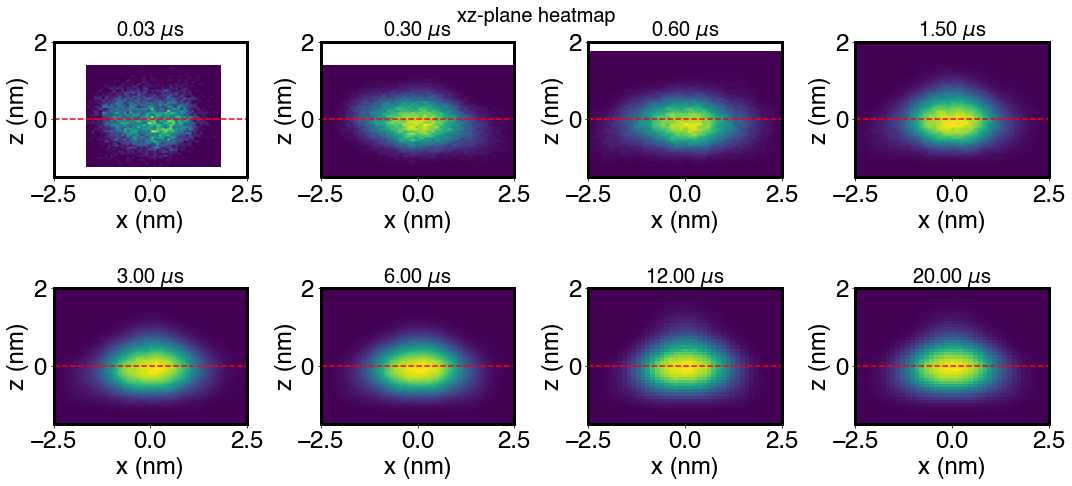

In [73]:
t_plot = np.array([100,1000,2000,5000,10000,20000,40000,np.shape(xyz_pro_cali)[0]])
fig = plt.figure(figsize=(15,7))
fig.suptitle('xz-plane heatmap', fontsize = 20)
for i in range(len(t_plot)):
    heatmap, xedges, zedges = np.histogram2d(xyz_pro_cali_mb[:t_plot[i],:,0].ravel(), xyz_pro_cali_mb[:t_plot[i],:,2].ravel(), bins=50, density=True)
    extent = [xedges[0], xedges[-1], zedges[0], zedges[-1]]
    plt.subplot(2,4,i+1)
    plt.imshow(heatmap.T, extent = extent, origin='lower')
    plt.plot([-2.5,2.5],[0,0],'r--')
    plt.xlim([-2.5,2.5])
    plt.ylim([-1.5,2])
    plt.xlabel('x (nm)')
    plt.ylabel('z (nm)')
    plt.title('%.2f $\mu$s'%(t_plot[i]*3/1e4), fontsize=20)
fig.tight_layout()

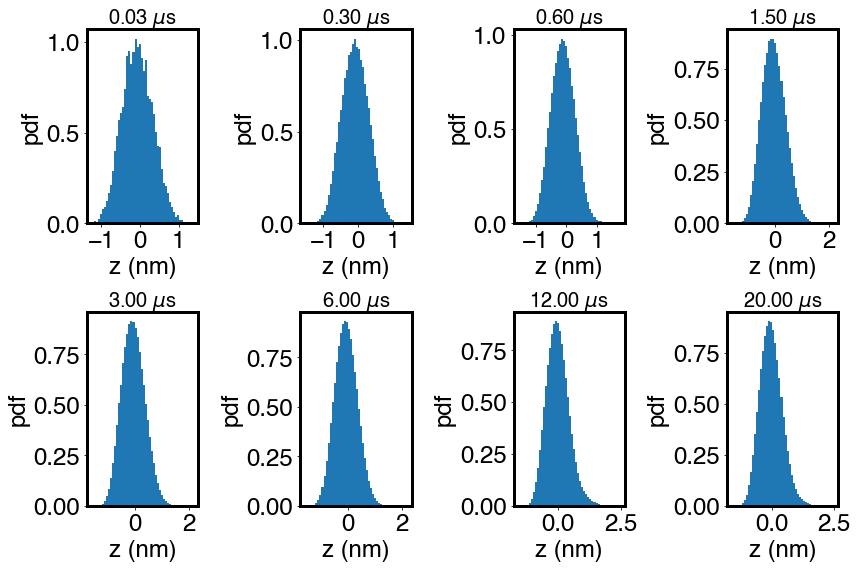

In [38]:
t_plot = np.array([100,1000,2000,5000,10000,20000,40000,np.shape(xyz_pro_cali)[0]])
fig = plt.figure(figsize=(12,8))

for i in range(len(t_plot)):
    plt.subplot(2,4,i+1)
    a = plt.hist(xyz_pro_cali_mb[:t_plot[i],:,2].ravel(), bins=50, density=True)
    #plt.xlim([-2,1])
    plt.xlabel('z (nm)')
    plt.ylabel('pdf')
    plt.title('%.2f $\mu$s'%(t_plot[i]*3/1e4), fontsize=20)
fig.tight_layout()